<a href="https://colab.research.google.com/github/laloflogar/RB2026/blob/main/Gr%C3%A1ficas_nacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gráfica 1: Producto Interno Bruto

In [ ]:
import numpy as np
import pandas as pd
import requests
from datetime import datetime
import plotly.graph_objects as go

Llamar a la API


In [ ]:
def descarga_bmx_series(series_dict, fechainicio, fechafin):
    # Token de acceso a la API de Banxico
    token = '26153e6c82692ded865088de00a0a217d9badd95674380b26b618a597e1285db'
    headers = {'Bmx-Token': token}
    all_data = []  # Lista para almacenar los DataFrames de cada serie

    # Itera sobre el diccionario de series proporcionado
    for serie, nombre in series_dict.items():
        # Construye la URL para la consulta API usando la serie y las fechas
        url = f'https://www.banxico.org.mx/SieAPIRest/service/v1/series/{serie}/datos/{fechainicio}/{fechafin}/'
        response = requests.get(url, headers=headers)  # Realiza la petición HTTP

        # Verifica si la respuesta es exitosa
        if response.status_code != 200:
            print(f'Error en la consulta para la serie {nombre}, código {response.status_code}')
            continue

        raw_data = response.json()  # Obtiene los datos en formato JSON

        # Verifica la estructura del JSON y si contiene datos
        if 'bmx' in raw_data and 'series' in raw_data['bmx'] and len(raw_data['bmx']['series']) > 0:
            serie_data = raw_data['bmx']['series'][0]

            if 'datos' in serie_data and len(serie_data['datos']) > 0:
                data = serie_data['datos']
                df = pd.DataFrame(data)
                # Elimina las comas antes de convertir a float
                df['dato'] = df['dato'].str.replace(',', '', regex=False).replace('N/E', np.nan).astype(float)  # Convierte los datos a float y maneja los no disponibles
                df['fecha'] = pd.to_datetime(df['fecha'], dayfirst=True)  # Convierte la columna de fecha al formato datetime
                df.set_index('fecha', inplace=True)  # Establece la columna de fecha como índice del DataFrame
                df.rename(columns={'dato': nombre}, inplace=True)  # Renombra la columna de datos con el nombre de la serie
                all_data.append(df)  # Agrega el DataFrame a la lista all_data
            else:
                print(f"No se encontraron datos para la serie {nombre}")
        else:
            print(f"Estructura inesperada en la respuesta para la serie {nombre}")

    # Concatena todos los DataFrames en uno solo si se descargaron datos
    if all_data:
        df_final = pd.concat(all_data, axis=1)
        return df_final
    else:
        print("No se descargaron datos.")
        return None

Crear el Dataframe

In [ ]:
# Define las series de datos y sus códigos correspondientes
series = {
    'SR17622': 'PIB Trimestral, a.e.'
}

# Define el rango de fechas de interés
fechainicio = '2010-01-01'
fechafin = pd.Timestamp.today().strftime('%Y-%m-%d')

# Llama a la función y asigna el resultado a df_final
df_final = descarga_bmx_series(series, fechainicio, fechafin)

# Verifica si se descargaron datos y muestra los primeros registros
if df_final is not None:
    print("Datos descargados exitosamente ✅ :")
    print(df_final.tail())  # Muestra los últimos registros para confirmar la descarga
else:
    print("No se pudo descargar ningún dato.")

Datos descargados exitosamente ✅ :
            PIB Trimestral, a.e.
fecha                           
2024-07-01            25464799.5
2024-10-01            25317392.2
2025-01-01            25375315.1
2025-04-01            25488536.9
2025-07-01            25415333.0


Calcular la variación trimestral

In [ ]:
# Filtrar el DataFrame desde 2018-01-01
df_filtered = df_final[df_final.index >= '2018-01-01'].copy()

# Obtener el valor del PIB para 2019-IV (cuarto trimestre de 2019, que inicia en 2019-10-01)
pib_2019_q4_value = df_filtered.loc['2019-10-01', 'PIB Trimestral, a.e.']

# Calcular el PIB como índice base 2019-IV=100
df_filtered['PIB_Base_2019_IV_100'] = (df_filtered['PIB Trimestral, a.e.'] / pib_2019_q4_value) * 100

# Calcular la variación respecto al trimestre anterior
df_filtered['Variacion_Trimestral'] = df_filtered['PIB Trimestral, a.e.'].pct_change() * 100

# Crear el nuevo DataFrame con las columnas solicitadas
df_pib_analisis = df_filtered[['PIB_Base_2019_IV_100', 'Variacion_Trimestral']]

print("DataFrame de análisis de PIB creado exitosamente ✅ :")
display(df_pib_analisis.head())
display(df_pib_analisis.tail())

DataFrame de análisis de PIB creado exitosamente ✅ :


,PIB_Base_2019_IV_100,Variacion_Trimestral
fecha,,
2018-01-01,101.087737,NaN
2018-04-01,100.777623,-0.306777
2018-07-01,101.190693,0.409883
2018-10-01,100.999888,-0.188560
2019-01-01,101.012675,0.012660


,PIB_Base_2019_IV_100,Variacion_Trimestral
fecha,,
2024-07-01,106.337029,0.909260
2024-10-01,105.721480,-0.578867
2025-01-01,105.963357,0.228787
2025-04-01,106.436153,0.446189
2025-07-01,106.130465,-0.287203


Graficar

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

# Create a figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add 'Variacion_Trimestral' as a bar chart (blue) on the primary y-axis
fig.add_trace(
    go.Bar(
        x=df_pib_analisis.index,
        y=df_pib_analisis['Variacion_Trimestral'],
        name='Variación Trimestral',
        marker_color='blue',
        yaxis='y1'
    )
)

# Add 'PIB_Base_2019_IV_100' as a line chart (red) on the secondary y-axis
fig.add_trace(
    go.Scatter(
        x=df_pib_analisis.index,
        y=df_pib_analisis['PIB_Base_2019_IV_100'],
        mode='lines',
        name='PIB Base 2019-IV=100',
        line=dict(color='red'),
        yaxis='y2'
    )
)

# Get min and max dates for vertical lines
min_date = df_pib_analisis.index.min()
max_date = df_pib_analisis.index.max()


# Update layout for dual Y-axes, title, subtitle, footnote, arrows, and axis ranges
fig.update_layout(
    title_text='<b>Gráfica 00: Producto Interno Bruto</b>', # Bold and centered title
    title_x=0.5,
    hovermode='x unified',
    plot_bgcolor='white', # White background
    width=700,
    height=500,
    # Define y-axes directly in layout
    xaxis=dict(
        showgrid=False,
        gridwidth=1,
        gridcolor='LightGrey',
        showline=True,
        linewidth=1,
        linecolor='black',
        mirror=False
    ),
    yaxis=dict(
        title_text=' ',
        range=[-6, 4], # Primary Y-axis range
        showline=True,
        linewidth=1,
        linecolor='blue',
        mirror=True,
        zeroline=True,
        zerolinecolor='lightgray',
        zerolinewidth=1,
        showgrid=False,
        gridwidth=1,
        gridcolor='LightGrey',
        title_font=dict(color="black"),
        tickfont=dict(color="black")
    ),
    yaxis2=dict(
        title_text=' ',
        range=[88, 108], # Secondary Y-axis range
        showline=True,
        linewidth=2,
        linecolor='gray',
        mirror=True,
        overlaying='y',
        side='right',
        zeroline=True,
        zerolinecolor='lightgray',
        zerolinewidth=1,
        showgrid=False,
        gridwidth=1,
        gridcolor='LightGrey',
        title_font=dict(color="black"),
        tickfont=dict(color="black")
    ),
    annotations=[
        # Subtitle
        dict(
            xref="paper", yref="paper",
            x=0.5, y=1.05,  # Position above the main title
            xanchor="center", yanchor="bottom",
            text="Variaciones trimestrales en por ciento e índice 2019-IV=100, a.e.",
            font=dict(size=14),
            showarrow=False
        ),
        # Footnote
        dict(
            xref="paper", yref="paper",
            x=0, y=-0.15, # Position below the x-axis
            xanchor="left", yanchor="top",
            text="Fuente: Elaboración propia con datos de Banxico.<br>*Se acotó la escala vertical para facilitar su lectura.",
            font=dict(size=10),
            showarrow=False
        ),
        # Red arrow
        dict(
            xref="paper", yref="paper",
            x=0.7, y=0.95, # Top-left corner of the plotting area
            text="",
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="red",
            ax=-60, ay=0, # Tail is 30 pixels left, 0 vertical offset from head
            xanchor="right", yanchor="bottom"
        ),
        #Blue arrow
        dict(
            xref="paper", yref="paper",
            x=0.8, y=0.75, # Top-right corner of the plotting area
            text="",
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="blue",
            ax=60, ay=0, # Tail is 30 pixels right, 0 vertical offset from head
            xanchor="left", yanchor="bottom"
        ),
        #Lines
        dict(
            xref="paper", yref="paper",
            x=0.265, y=0,
            text="",
            showarrow=True,
            arrowhead=0,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="black",
            ax=30, ay=-5,
            xanchor="left", yanchor="bottom"
        ),
        dict(
            xref="paper", yref="paper",
            x=0.265, y=0.015,
            text="",
            showarrow=True,
            arrowhead=0,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="black",
            ax=30, ay=-5,
            xanchor="left", yanchor="bottom"
        ),
        dict(
            xref="paper", yref="paper",
            x=0.3, y=0.98,
            text="",
            showarrow=True,
            arrowhead=0,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="black",
            ax=38, ay=-5,
            xanchor="left", yanchor="bottom"
        ),
        dict(
            xref="paper", yref="paper",
            x=0.3, y=0.96,
            text="",
            showarrow=True,
            arrowhead=0,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="black",
            ax=38, ay=-5,
            xanchor="left", yanchor="bottom"
        ),

        # Data labels for 2020-Q2, Q3, Q4
        dict(
            x='2019-11-01', y=-5.9,
            text=f"{df_pib_analisis.loc['2020-04-01', 'Variacion_Trimestral']:.2f}",
            showarrow=False, yshift=10, font=dict(color="blue", size=10)
        ),
        dict(
            x='2020-02-01', y=3.65,
            text=f"{df_pib_analisis.loc['2020-07-01', 'Variacion_Trimestral']:.2f}",
            showarrow=False, yshift=10, font=dict(color="blue", size=10)
        ),
        dict(
            x='2021-03-01', y=3.65,
            text=f"{df_pib_analisis.loc['2020-10-01', 'Variacion_Trimestral']:.2f}",
            showarrow=False, yshift=10, font=dict(color="blue", size=10)
        ),
        dict(
            x='2020-11-01', y=-5.9,
            text=f"{df_pib_analisis.loc['2020-04-01', 'PIB_Base_2019_IV_100']:.2f}",
            showarrow=False, yshift=10, font=dict(color="red", size=10)
        )
    ],
    legend=dict(
        x=0.94, # Right side of the plot
        y=0.01, # Bottom of the plot
        xanchor='right', # Anchor the legend to the right
        yanchor='bottom', # Anchor the legend to the bottom
        bgcolor='rgba(255, 255, 255, 0.5)', # Optional: translucent background
        bordercolor='rgba(0, 0, 0, 0)'
    )
)

fig.show()

# Gráfica 2: variaciones anuales en por ciento

Llamado al API

In [25]:
import requests
import json
import pandas as pd

#Llamado al API
token='337db32f-2268-33f9-43e8-c853b84b6ee9'
original='735904' # Serie para PIB Original
desest='736183' # Serie para PIB Desestacionalizado
fecha_inicio='2018-01-01'
url1='https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/'+original+'/es/00/false/BIE-BISE/2.0/'+token+'?type=jsonn'
url2='https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/'+desest+'/es/00/false/BIE-BISE/2.0/'+token+'?type=jsonn'


# VARIACIÓN DEL PIB SERIES ORIGINALES
response = requests.get(url1)
if response.status_code == 200:
    content = json.loads(response.content)
    series_original = content['Series'][0]['OBSERVATIONS']

    # Crear DataFrame para la serie original
    df_original = pd.DataFrame(series_original)
    df_original = df_original.rename(columns={'OBS_VALUE': 'var_PIB_original'})
    df_original['var_PIB_original'] = pd.to_numeric(df_original['var_PIB_original'], errors='coerce')
    df_original = df_original[['TIME_PERIOD', 'var_PIB_original']]
else:
    print(f"Error al obtener datos de la serie original: {response.status_code}")
    df_original = pd.DataFrame()

# VARIACIÓN DEL PIB SERIES DESESTACIONALIZADAS
response = requests.get(url2)
if response.status_code == 200:
    content = json.loads(response.content)
    series_desest = content['Series'][0]['OBSERVATIONS']

    # Crear DataFrame para la serie desestacionalizada
    df_desest = pd.DataFrame(series_desest)
    df_desest = df_desest.rename(columns={'OBS_VALUE': 'var_PIB_desest'})
    df_desest['var_PIB_desest'] = pd.to_numeric(df_desest['var_PIB_desest'], errors='coerce')
    df_desest = df_desest[['TIME_PERIOD', 'var_PIB_desest']]
else:
    print(f"Error al obtener datos de la serie desestacionalizada: {response.status_code}")
    df_desest = pd.DataFrame()

# Fusionar los DataFrames si ambos tienen datos
if not df_original.empty and not df_desest.empty:
    base = pd.merge(df_original, df_desest, on='TIME_PERIOD', how='outer')
elif not df_original.empty:
    base = df_original
elif not df_desest.empty:
    base = df_desest
else:
    base = pd.DataFrame() # Crear un DataFrame vacío si no se pudo descargar ningún dato

# Convert TIME_PERIOD to datetime objects
if not base.empty:
    base['TIME_PERIOD'] = pd.to_datetime(base['TIME_PERIOD'], format='%Y/%m')

# Set TIME_PERIOD as index
base = base.set_index('TIME_PERIOD')

# Filtrar el Dataframe desde la fecha de inicio
base_filtrada = base[base.index >= fecha_inicio].copy()

display(base_filtrada.head())
display(base_filtrada.tail())

,var_PIB_original,var_PIB_desest
TIME_PERIOD,,
2018-01-01,1.125548,2.169519
2018-02-01,2.890753,1.743777
2018-03-01,2.750042,2.768490
2018-04-01,1.136534,1.162598
2019-01-01,0.942800,-0.074254


,var_PIB_original,var_PIB_desest
TIME_PERIOD,,
2024-03-01,1.400972,1.280210
2024-04-01,0.267262,0.368927
2025-01-01,0.558752,0.419863
2025-02-01,-0.068081,1.003324
2025-03-01,-0.119997,-0.194255


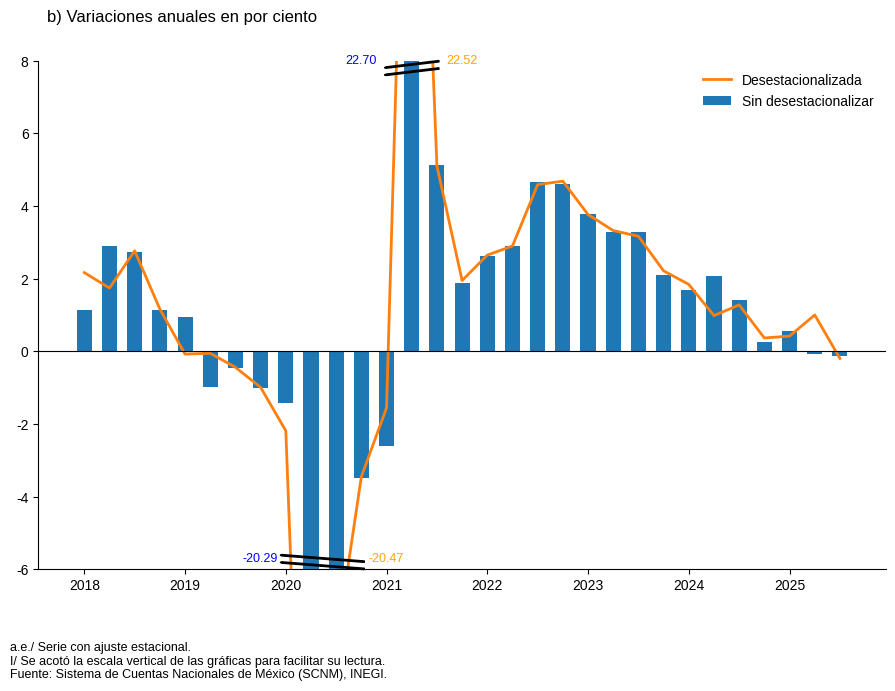

In [26]:
import matplotlib.pyplot as plt
import numpy as np

#Tipografía
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'Liberation Sans']
plt.rcParams['axes.unicode_minus'] = False

# 1. Asegurar orden y convertir a PeriodIndex trimestral
df = base_filtrada.copy().sort_index()
df.index = df.index.to_period('Q')

# 2. Crear eje X numérico uniforme
x = np.arange(len(df))

# 3. Figura
fig, ax = plt.subplots(figsize=(9, 7)) # Aumentar el tamaño de la figura

# 4. Barras: sin desestacionalizar
ax.bar(
    x,
    df['var_PIB_original'],
    width=0.6,
    color='#1f77b4',
    label='Sin desestacionalizar'
)

# 5. Línea: desestacionalizada
ax.plot(
    x,
    df['var_PIB_desest'],
    color='#ff7f0e',
    linewidth=2,
    label='Desestacionalizada'
)

# 6. Línea horizontal en cero
ax.axhline(0, color='black', linewidth=0.8)

# 7. Etiquetas del eje X (solo años)
ax.set_xticks(x[::4])
ax.set_xticklabels(df.index.astype(str)[::4].str[:4])

# 8. Límites eje Y
ax.set_ylim(-6, 8)

# 9. Títulos y formato
fig.suptitle('', ha='left', x=0.3, y=0.95, fontsize=16) # Título principal de la figura
ax.set_title('b) Variaciones anuales en por ciento', x=0.01, y=1.05, loc='left', pad=10) # Aumentar el padding del título

ax.legend(frameon=False)

# Estilo limpio
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Lineas de acotación
ax.annotate(
    '',  # Sin texto
    xy=(x[0] + 7.6, -5.8),  # Cabeza de la flecha (punto final)
    xytext=(x[0] + 11.3, -6),  # Cola de la flecha (punto inicial)
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=1, headlength=1)
)
ax.annotate(
    '',  # Sin texto
    xy=(x[0] + 7.6, -5.6),  # Cabeza de la flecha (punto final)
    xytext=(x[0] + 11.3, -5.8),  # Cola de la flecha (punto inicial)
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=1, headlength=1)
)
ax.annotate(
    '',  # Sin texto
    xy=(x[0] + 11.8, +7.8),  # Cabeza de la flecha (punto final)
    xytext=(x[0] + 14.2, +8),  # Cola de la flecha (punto inicial)
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=1, headlength=1)
)
ax.annotate(
    '',  # Sin texto
    xy=(x[0] + 11.8, +7.6),  # Cabeza de la flecha (punto final)
    xytext=(x[0] + 14.2, +7.8),  # Cola de la flecha (punto inicial)
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=1, headlength=1)
)

# Etiquetas de datos mínimos y máximos
# Para 'var_PIB_original' (barras)
min_original_value = df['var_PIB_original'].min()
max_original_value = df['var_PIB_original'].max()
min_original_idx = df['var_PIB_original'].idxmin()
max_original_idx = df['var_PIB_original'].idxmax()

x_coords = {idx: i for i, idx in enumerate(df.index)}

ax.annotate(f'{min_original_value:.2f}',
            xy=(0, 0),
            xytext=(7, -5.7),# Centered vertically
            ha='center', va='center', color='blue', fontsize=9)
ax.annotate(f'{max_original_value:.2f}',
            xy=(0, 0),
            xytext=(11, 8), # Centered vertically
            ha='center', va='center', color='blue', fontsize=9)

# Para 'var_PIB_desest' (línea)
min_desest_value = df['var_PIB_desest'].min()
max_desest_value = df['var_PIB_desest'].max()
min_desest_idx = df['var_PIB_desest'].idxmin()
max_desest_idx = df['var_PIB_desest'].idxmax()

ax.annotate(f'{min_desest_value:.2f}',
            xy=(0, 0),
            xytext=(12, -5.7), # Centered vertically
            ha='center', va='center', color='orange', fontsize=9)
ax.annotate(f'{max_desest_value:.2f}',
            xy=(0, 0),
            xytext=(15, 8), # Centered vertically
            ha='center', va='center', color='orange', fontsize=9)


# Nota al pie
plt.figtext(
    0.01, -0.05, # Ajustar la posición y para dar más espacio
    'a.e./ Serie con ajuste estacional.\n'
    'I/ Se acotó la escala vertical de las gráficas para facilitar su lectura.\n'
    'Fuente: Sistema de Cuentas Nacionales de México (SCNM), INEGI.',
    ha='left',
    fontsize=9
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Ajustar tight_layout para dejar espacio al suptitle y figtext
plt.show()

# Gráfica 3: IGAE

In [4]:
import requests
import json
import pandas as pd
from functools import reduce

# Configuración
token = '337db32f-2268-33f9-43e8-c853b84b6ee9'
# Define series_ids as a dictionary to correctly map IDs to names
series_ids = {
    '737219': "IGAE Total Desest",
    '737222': "IGAE Total Tenden",
    '737226': "IGAE Prim Desest",
    '737229': "IGAE Prim Tenden",
    '737233': "IGAE Sec Desest",
    '737236': "IGAE Sec Tenden",
    '737268': "IGAE Ter Desest",
    '737271': "IGAE Ter Tenden"

}

# Modify obtener_serie to accept and use the series_name for column renaming
def obtener_serie(serieID, token, serie_name):
    url = f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{serieID}/es/00/false/BIE-BISE/2.0/{token}?type=json'
    response = requests.get(url)

    if response.status_code == 200:
        content = json.loads(response.content)
        observations = content['Series'][0]['OBSERVATIONS']

        # Crear DataFrame temporal
        df = pd.DataFrame(observations)

        # Mantener solo fecha y valor, renombrando el valor con el nombre descriptivo
        df = df[['TIME_PERIOD', 'OBS_VALUE']].copy()
        df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')
        df.rename(columns={'OBS_VALUE': serie_name}, inplace=True) # Use descriptive name here

        return df
    else:
        print(f"Error al consultar la serie {serieID} ({serie_name}), código {response.status_code}")
        return None

# 1. Obtener todas las series en una lista
# Iterate over dictionary items to get both ID and name
lista_dataframes = [obtener_serie(id, token, name) for id, name in series_ids.items()]

# 2. Eliminar posibles errores (Nones) de la lista
lista_dataframes = [df for df in lista_dataframes if df is not None]

# 3. Unir todos los DataFrames por la columna 'TIME_PERIOD'
# Asegúrate de que lista_dataframes no esté vacío para evitar un error con reduce
if lista_dataframes:
    df_final = reduce(lambda left, right: pd.merge(left, right, on='TIME_PERIOD', how='outer'), lista_dataframes)
else:
    df_final = pd.DataFrame() # O maneja el caso de no datos de otra manera

# Ordenar por fecha para que tenga sentido cronológico
df_final = df_final.sort_values('TIME_PERIOD').reset_index(drop=True)

# Establecer TIME_PERIOD como index
df_final = df_final.set_index('TIME_PERIOD')

print(df_final)

             IGAE Total Desest  IGAE Total Tenden  IGAE Prim Desest  \
TIME_PERIOD                                                           
1993/01              56.398617          57.022728         62.770882   
1993/02              57.585976          57.206802         64.401765   
1993/03              57.764828          57.396801         60.706049   
1993/04              57.191816          57.579480         60.009716   
1993/05              57.927359          57.749843         62.969347   
...                        ...                ...               ...   
2025/06             104.986432         104.886376        108.222131   
2025/07             104.609807         104.891050        108.158140   
2025/08             105.072599         104.944886        118.731531   
2025/09             104.611082         105.065584        113.169767   
2025/10             105.637562         105.235725        114.775218   

             IGAE Prim Tenden  IGAE Sec Desest  IGAE Sec Tenden  \
TIME_PERI

In [5]:
df_rebased = df_final.copy()

# Convert TIME_PERIOD index to datetime objects if it's not already
df_rebased.index = pd.to_datetime(df_rebased.index, format='%Y/%m')

# Filter for the year 2019 to get the base values
df_2019 = df_rebased[df_rebased.index.year == 2019]

# Calculate the average for 2019 for both series
base_value_desest1 = df_2019['IGAE Total Desest'].mean()
base_value_tenden1 = df_2019['IGAE Total Tenden'].mean()
base_value_desest2 = df_2019['IGAE Prim Desest'].mean()
base_value_tenden2 = df_2019['IGAE Prim Tenden'].mean()
base_value_desest3 = df_2019['IGAE Sec Desest'].mean()
base_value_tenden3 = df_2019['IGAE Sec Tenden'].mean()
base_value_desest4 = df_2019['IGAE Ter Desest'].mean()
base_value_tenden4 = df_2019['IGAE Ter Tenden'].mean()

# Rebase the series to 2019=100
df_rebased['IGAE Total Desest (2019=100)'] = (df_rebased['IGAE Total Desest'] / base_value_desest1) *100
df_rebased['IGAE Total Tenden (2019=100)'] = (df_rebased['IGAE Total Tenden'] / base_value_tenden1) *100
df_rebased['IGAE Prim Desest (2019=100)'] = (df_rebased['IGAE Prim Desest'] / base_value_desest2) *100
df_rebased['IGAE Prim Tenden (2019=100)'] = (df_rebased['IGAE Prim Tenden'] / base_value_tenden2) *100
df_rebased['IGAE Sec Desest (2019=100)'] = (df_rebased['IGAE Sec Desest'] / base_value_desest3) *100
df_rebased['IGAE Sec Tenden (2019=100)'] = (df_rebased['IGAE Sec Tenden'] / base_value_tenden3) *100
df_rebased['IGAE Ter Desest (2019=100)'] = (df_rebased['IGAE Ter Desest'] / base_value_desest4) *100
df_rebased['IGAE Ter Tenden (2019=100)'] = (df_rebased['IGAE Ter Tenden'] / base_value_tenden4) *100

# Display the head and tail of the new DataFrame with rebased columns
print("DataFrame con IGAE rebasado a 2019=100:")
display(df_rebased.head())
display(df_rebased.tail())

DataFrame con IGAE rebasado a 2019=100:


,IGAE Total Desest,IGAE Total Tenden,IGAE Prim Desest,IGAE Prim Tenden,IGAE Sec Desest,IGAE Sec Tenden,IGAE Ter Desest,IGAE Ter Tenden,IGAE Total Desest (2019=100),IGAE Total Tenden (2019=100),IGAE Prim Desest (2019=100),IGAE Prim Tenden (2019=100),IGAE Sec Desest (2019=100),IGAE Sec Tenden (2019=100),IGAE Ter Desest (2019=100),IGAE Ter Tenden (2019=100)
TIME_PERIOD,,,,,,,,,,,,,,,,
1993-01-01,56.398617,57.022728,62.770882,62.556354,63.257404,65.753458,52.308699,52.675941,56.633024,57.259666,62.377349,62.225678,64.345883,66.865376,52.177811,52.557541
1993-02-01,57.585976,57.206802,64.401765,62.618018,65.756639,65.702508,52.998081,52.816738,57.825318,57.444505,63.998007,62.287016,66.888122,66.813565,52.865468,52.698021
1993-03-01,57.764828,57.396801,60.706049,62.380794,66.225290,65.635789,53.107748,52.963109,58.004913,57.635294,60.325461,62.051045,67.364837,66.745717,52.974860,52.844063
1993-04-01,57.191816,57.579480,60.009716,62.282265,65.394235,65.540966,52.988365,53.102877,57.429519,57.818732,59.633494,61.953037,66.519482,66.649291,52.855776,52.983517
1993-05-01,57.927359,57.749843,62.969347,62.182997,65.405744,65.440114,53.298550,53.222926,58.168119,57.989803,62.574570,61.854295,66.531189,66.546733,53.165185,53.103296


,IGAE Total Desest,IGAE Total Tenden,IGAE Prim Desest,IGAE Prim Tenden,IGAE Sec Desest,IGAE Sec Tenden,IGAE Ter Desest,IGAE Ter Tenden,IGAE Total Desest (2019=100),IGAE Total Tenden (2019=100),IGAE Prim Desest (2019=100),IGAE Prim Tenden (2019=100),IGAE Sec Desest (2019=100),IGAE Sec Tenden (2019=100),IGAE Ter Desest (2019=100),IGAE Ter Tenden (2019=100)
TIME_PERIOD,,,,,,,,,,,,,,,,
2025-06-01,104.986432,104.886376,108.222131,110.450137,101.409841,101.028873,106.797426,106.748863,105.422781,105.322196,107.543649,109.866292,103.154814,102.737313,106.530195,106.508922
2025-07-01,104.609807,104.891050,108.158140,111.306565,100.313778,100.634096,106.723795,106.923670,105.044591,105.326890,107.480058,110.718192,102.039890,102.335861,106.456749,106.683336
2025-08-01,105.072599,104.944886,118.731531,111.854411,100.033389,100.334872,107.291054,107.183758,105.509307,105.380949,117.987162,111.263142,101.754677,102.031576,107.022588,106.942839
2025-09-01,104.611082,105.065584,113.169767,112.111285,99.763496,100.218447,107.021287,107.508480,105.045871,105.502148,112.460266,111.518659,101.480140,101.913183,106.753496,107.266831
2025-10-01,105.637562,105.235725,114.775218,112.120274,100.501724,100.256247,108.290561,107.853979,106.076617,105.672997,114.055652,111.527600,102.231070,101.951621,108.019594,107.611553


In [6]:
fecha_inicio='2018-01-01'
base_filtrada = df_rebased[df_rebased.index >= fecha_inicio].copy()
display(base_filtrada.tail())

,IGAE Total Desest,IGAE Total Tenden,IGAE Prim Desest,IGAE Prim Tenden,IGAE Sec Desest,IGAE Sec Tenden,IGAE Ter Desest,IGAE Ter Tenden,IGAE Total Desest (2019=100),IGAE Total Tenden (2019=100),IGAE Prim Desest (2019=100),IGAE Prim Tenden (2019=100),IGAE Sec Desest (2019=100),IGAE Sec Tenden (2019=100),IGAE Ter Desest (2019=100),IGAE Ter Tenden (2019=100)
TIME_PERIOD,,,,,,,,,,,,,,,,
2025-06-01,104.986432,104.886376,108.222131,110.450137,101.409841,101.028873,106.797426,106.748863,105.422781,105.322196,107.543649,109.866292,103.154814,102.737313,106.530195,106.508922
2025-07-01,104.609807,104.891050,108.158140,111.306565,100.313778,100.634096,106.723795,106.923670,105.044591,105.326890,107.480058,110.718192,102.039890,102.335861,106.456749,106.683336
2025-08-01,105.072599,104.944886,118.731531,111.854411,100.033389,100.334872,107.291054,107.183758,105.509307,105.380949,117.987162,111.263142,101.754677,102.031576,107.022588,106.942839
2025-09-01,104.611082,105.065584,113.169767,112.111285,99.763496,100.218447,107.021287,107.508480,105.045871,105.502148,112.460266,111.518659,101.480140,101.913183,106.753496,107.266831
2025-10-01,105.637562,105.235725,114.775218,112.120274,100.501724,100.256247,108.290561,107.853979,106.076617,105.672997,114.055652,111.527600,102.231070,101.951621,108.019594,107.611553


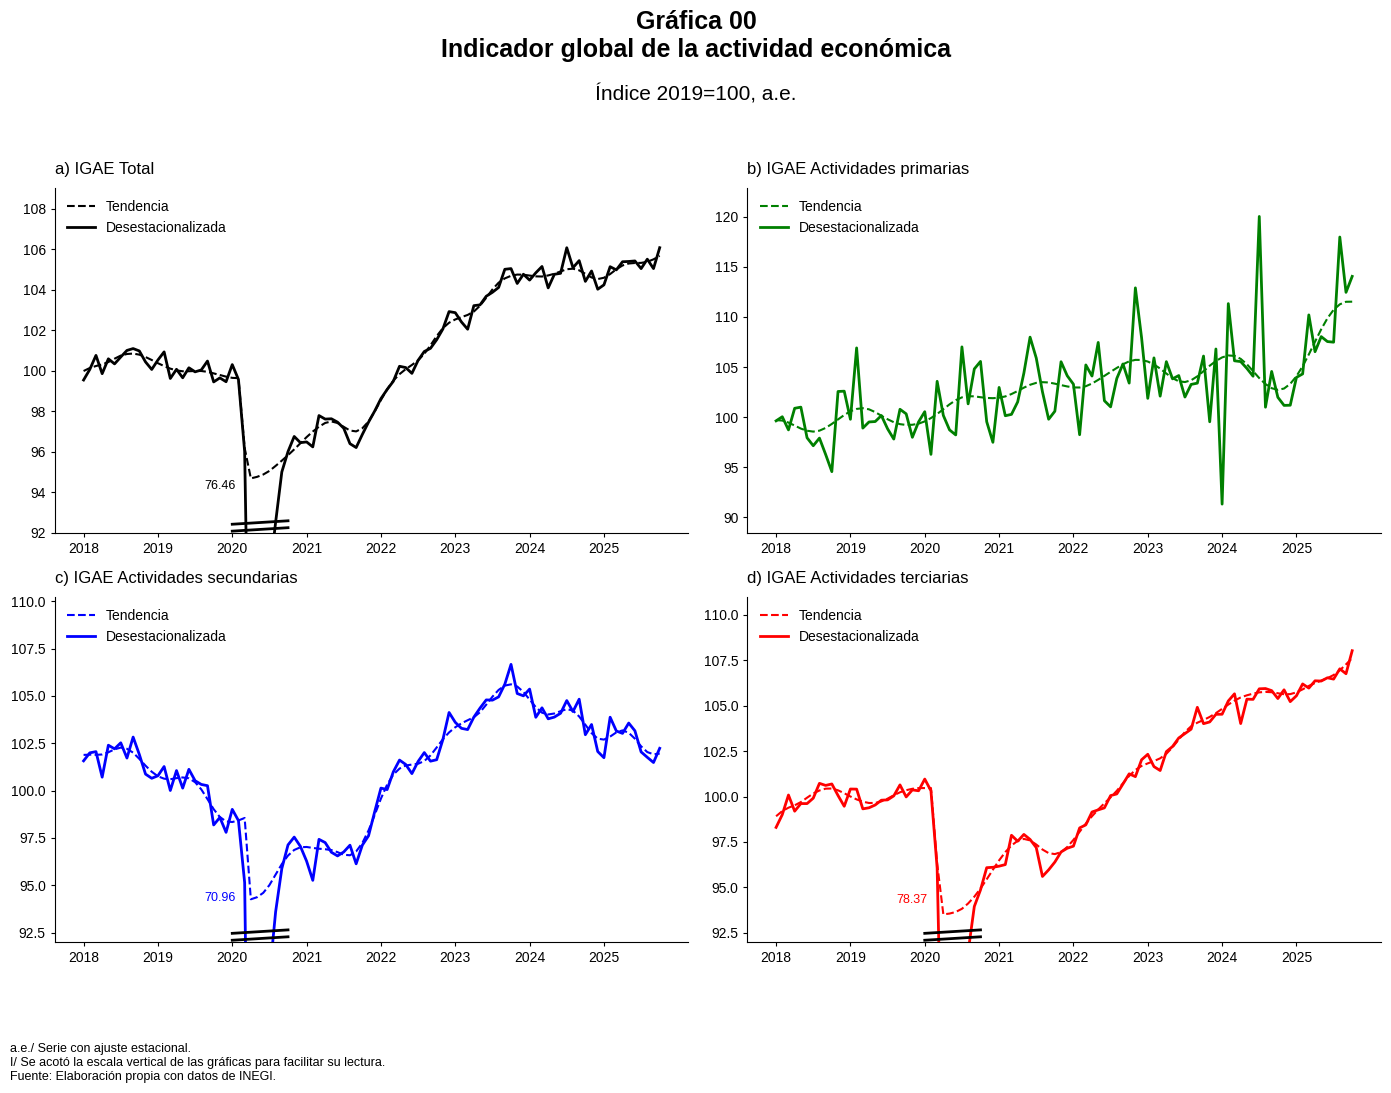

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Tipografía
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'Liberation Sans']
plt.rcParams['axes.unicode_minus'] = False

# Ensure the index is PeriodIndex('Q') for consistent x-axis handling
df_plot = base_filtrada.copy().sort_index()
df_plot.index = df_plot.index.to_period('M') # Convert to monthly period for consistency with previous plotting logic

# Define the series to plot and their colors
series_to_plot = {
    'IGAE Total': {'desest': 'IGAE Total Desest (2019=100)', 'tenden': 'IGAE Total Tenden (2019=100)', 'color': 'black', 'title_prefix': 'a)'},
    'IGAE Actividades primarias': {'desest': 'IGAE Prim Desest (2019=100)', 'tenden': 'IGAE Prim Tenden (2019=100)', 'color': 'green', 'title_prefix': 'b)'},
    'IGAE Actividades secundarias': {'desest': 'IGAE Sec Desest (2019=100)', 'tenden': 'IGAE Sec Tenden (2019=100)', 'color': 'blue', 'title_prefix': 'c)'},
    'IGAE Actividades terciarias': {'desest': 'IGAE Ter Desest (2019=100)', 'tenden': 'IGAE Ter Tenden (2019=100)', 'color': 'red', 'title_prefix': 'd)'}
}

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=False) # Increased figure size
axes = axes.flatten() # Flatten the 2x2 array of axes for easy iteration

# Create numeric x-axis
x = np.arange(len(df_plot))

# X-axis labels (only years for monthly data)
year_labels = df_plot.index.strftime('%Y').unique()
jan_indices = [i for i, date in enumerate(df_plot.index) if date.month == 1]
start_year = df_plot.index.year.min()
end_year = df_plot.index.year.max()
jan_x_ticks = []
jan_x_labels = []
for i in jan_indices:
    if df_plot.index[i].year >= start_year and df_plot.index[i].year <= end_year:
        jan_x_ticks.append(x[i])
        jan_x_labels.append(str(df_plot.index[i].year))

# Calculate the starting x-coordinate for 2020 and the line length
x_start_2020 = jan_x_ticks[jan_x_labels.index('2020')] # x-coordinate for the beginning of 2020
line_length = x[int(len(x) / 10)] - x[0] # Original line length

# Calculate the x-coordinate for November 2019
x_nov_2019_idx = df_plot.index.get_loc(pd.Period('2019-11', freq='M'))
x_nov_2019 = x[x_nov_2019_idx]

for i, (sector, data) in enumerate(series_to_plot.items()):
    ax = axes[i]
    color = data['color']
    title_prefix = data['title_prefix']

    # Plot Tendencia (dashed line)
    ax.plot(
        x,
        df_plot[data['tenden']],
        color=color,
        label='Tendencia',
        linestyle='--'
    )

    # Plot Desestacionalizada (solid line)
    ax.plot(
        x,
        df_plot[data['desest']],
        color=color,
        linewidth=2,
        label='Desestacionalizada'
    )

    # Linea horizontal en cero
    ax.axhline(0, color='lightgray', linewidth=0.8)

    # X-axis labels
    ax.set_xticks(jan_x_ticks)
    ax.set_xticklabels(jan_x_labels)

    # Y-axis limits (dynamic for each subplot)
    min_val_desest = df_plot[data['desest']].min()
    max_val_desest = df_plot[data['desest']].max()
    min_val_tenden = df_plot[data['tenden']].min()
    max_val_tenden = df_plot[data['tenden']].max()

    min_overall = min(min_val_desest, min_val_tenden)
    max_overall = max(max_val_desest, max_val_tenden)

    padding_y = (max_overall - min_overall) * 0.1

    # Set y-axis start for panels 'a', 'c', and 'd'
    if sector in ['IGAE Total', 'IGAE Actividades secundarias', 'IGAE Actividades terciarias']:
        ax.set_ylim(92, max_overall + padding_y)

        # Add a slightly inclined line for panels 'a', 'c', 'd'
        ymin, ymax_current = ax.get_ylim()
        line_y_start = ymin + (ymax_current - ymin) * 0.025
        line_y_end = ymin + (ymax_current - ymin) * 0.035 # Slight inclination
        ax.plot([x_start_2020, x_start_2020 + line_length], [line_y_start, line_y_end], color='black', linewidth=2)
        # Second parallel line
        line_y_start_2 = ymin + (ymax_current - ymin) * 0.005 # Slightly lower than the first line
        line_y_end_2 = ymin + (ymax_current - ymin) * 0.015 # Slightly lower than the first line_y_end
        ax.plot([x_start_2020, x_start_2020 + line_length], [line_y_start_2, line_y_end_2], color='black', linewidth=2)

        # Add labels for minimum value of deseasonalized series
        desest_col = data['desest']
        min_val_desest = df_plot[desest_col].min()
        min_date_desest = df_plot[desest_col].idxmin() # This returns a Period('YYYY-MM', freq='M')
        min_x_coord_desest = x[df_plot.index.get_loc(min_date_desest)] # Get x-coord of actual minimum
        min_y_coord_desest = min_val_desest

        # Position the text slightly above ymin
        text_y_position = ymin + 2 # Increased offset for better visibility

        ax.annotate(f'{min_val_desest:.2f}',
                    xy=(min_x_coord_desest, 92), # Actual data point
                    xytext=(x_nov_2019, text_y_position),        # Text position (Nov 2019, bottom)
                    arrowprops=dict(facecolor=color, shrink=0.05, width=0, headwidth=0, headlength=0),
                    fontsize=9, color=color, ha='center', va='bottom')
    else:
        ax.set_ylim(min_overall - padding_y, max_overall + padding_y)

    # Titles and format
    ax.set_title(f'{title_prefix} {sector}', loc='left', pad=10)
    ax.legend(frameon=False, loc='upper left') # Legend for each subplot

    # Clean style
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(axis='x', length=3, labelbottom=True) # Ensure x-axis tick marks and labels are visible
    ax.tick_params(axis='y', length=3) # Ensure y-axis tick marks are visible
    ax.grid(axis='y', linestyle='', alpha=0.7)

# Adjust layout and add overall title and footnote
fig.suptitle('Gráfica 00\nIndicador global de la actividad económica', ha='center', y=1.02, fontsize=18, fontweight='bold') # Use 'color' and 'fontweight'
#Subtítulo
plt.figtext(
    0.5, 0.93, # Adjust position to be below suptitle and centered
    'Índice 2019=100, a.e.',
    ha='center', # Center horizontally
    fontsize=15
)
# Footnote
plt.figtext(
    0.01, -0.05, # Adjust position to avoid overlap with subtitle or main title
    'a.e./ Serie con ajuste estacional.\n' # Added line break
    'I/ Se acotó la escala vertical de las gráficas para facilitar su lectura.\n'
    'Fuente: Elaboración propia con datos de INEGI.',
    ha='left',
    fontsize=9
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjusted rect to have 4 values
plt.show()

# Gráfica 4: Indicador mensual de la actividad industrial

In [27]:
import requests
import json
import pandas as pd
from functools import reduce

# Configuración
token = '337db32f-2268-33f9-43e8-c853b84b6ee9'
# Define series_ids as a dictionary to correctly map IDs to names
series_ids = {
    '737261': "Manufacturas Desest",
    '737264': "Manufacturas Tenden",
    '737240': "Minería Desest",
    '737243': "Minería Tenden",
    '737254': "Construcción Desest",
    '737257': "Construcción Tenden",
    '737247': "Electricidad, agua y gas Desest",
    '737250': "Electricidad, agua y gas Tenden"

}

# Modify obtener_serie to accept and use the series_name for column renaming
def obtener_serie(serieID, token, serie_name):
    url = f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{serieID}/es/00/false/BIE-BISE/2.0/{token}?type=json'
    response = requests.get(url)

    if response.status_code == 200:
        content = json.loads(response.content)
        observations = content['Series'][0]['OBSERVATIONS']

        # Crear DataFrame temporal
        df = pd.DataFrame(observations)

        # Mantener solo fecha y valor, renombrando el valor con el nombre descriptivo
        df = df[['TIME_PERIOD', 'OBS_VALUE']].copy()
        df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')
        df.rename(columns={'OBS_VALUE': serie_name}, inplace=True) # Use descriptive name here

        return df
    else:
        print(f"Error al consultar la serie {serieID} ({serie_name}), código {response.status_code}")
        return None

# 1. Obtener todas las series en una lista
# Iterate over dictionary items to get both ID and name
lista_dataframes = [obtener_serie(id, token, name) for id, name in series_ids.items()]

# 2. Eliminar posibles errores (Nones) de la lista
lista_dataframes = [df for df in lista_dataframes if df is not None]

# 3. Unir todos los DataFrames por la columna 'TIME_PERIOD'
# Asegúrate de que lista_dataframes no esté vacío para evitar un error con reduce
if lista_dataframes:
    df_final = reduce(lambda left, right: pd.merge(left, right, on='TIME_PERIOD', how='outer'), lista_dataframes)
else:
    df_final = pd.DataFrame() # O maneja el caso de no datos de otra manera

# Ordenar por fecha para que tenga sentido cronológico
df_final = df_final.sort_values('TIME_PERIOD').reset_index(drop=True)

# Establecer TIME_PERIOD como index
df_final = df_final.set_index('TIME_PERIOD')

print(df_final)

             Manufacturas Desest  Manufacturas Tenden  Minería Desest  \
TIME_PERIOD                                                             
1993/01                56.769541            58.257264      103.826568   
1993/02                59.072152            58.545996      104.848361   
1993/03                59.775981            58.825780      106.027502   
1993/04                59.202204            59.039816      106.687303   
1993/05                58.829685            59.198748      106.179290   
...                          ...                  ...             ...   
2025/06               107.041914           106.483725       85.264959   
2025/07               105.369411           106.028770       87.656494   
2025/08               105.404425           105.668488       87.940957   
2025/09               105.594440           105.485219       88.577428   
2025/10               105.263446           105.454817       89.204034   

             Minería Tenden  Construcción Desest  

In [28]:
df_rebased = df_final.copy()

# Convert TIME_PERIOD index to datetime objects if it's not already
df_rebased.index = pd.to_datetime(df_rebased.index, format='%Y/%m')

# Filter for the year 2019 to get the base values
df_2019 = df_rebased[df_rebased.index.year == 2019]

# Calculate the average for 2019 for both series
base_value_desest1 = df_2019['Manufacturas Desest'].mean()
base_value_tenden1 = df_2019['Manufacturas Tenden'].mean()
base_value_desest2 = df_2019['Minería Desest'].mean()
base_value_tenden2 = df_2019['Minería Tenden'].mean()
base_value_desest3 = df_2019['Construcción Desest'].mean()
base_value_tenden3 = df_2019['Construcción Tenden'].mean()
base_value_desest4 = df_2019['Electricidad, agua y gas Desest'].mean()
base_value_tenden4 = df_2019['Electricidad, agua y gas Tenden'].mean()

# Rebase the series to 2019=100
df_rebased['Manufacturas Desest (2019=100)'] = (df_rebased['Manufacturas Desest'] / base_value_desest1) *100
df_rebased['Manufacturas Tenden (2019=100)'] = (df_rebased['Manufacturas Tenden'] / base_value_tenden1) *100
df_rebased['Minería Desest (2019=100)'] = (df_rebased['Minería Desest'] / base_value_desest2) *100
df_rebased['Minería Tenden (2019=100)'] = (df_rebased['Minería Tenden'] / base_value_tenden2) *100
df_rebased['Construcción Desest (2019=100)'] = (df_rebased['Construcción Desest'] / base_value_desest3) *100
df_rebased['Construcción Tenden (2019=100)'] = (df_rebased['Construcción Tenden'] / base_value_tenden3) *100
df_rebased['Electricidad, agua y gas Desest (2019=100)'] = (df_rebased['Electricidad, agua y gas Desest'] / base_value_desest4) *100
df_rebased['Electricidad, agua y gas Tenden (2019=100)'] = (df_rebased['Electricidad, agua y gas Tenden'] / base_value_tenden4) *100

# Display the head and tail of the new DataFrame with rebased columns
print("DataFrame con IGAE rebasado a 2019=100:")
display(df_rebased.head())
display(df_rebased.tail())

DataFrame con IGAE rebasado a 2019=100:


,Manufacturas Desest,Manufacturas Tenden,Minería Desest,Minería Tenden,Construcción Desest,Construcción Tenden,"Electricidad, agua y gas Desest","Electricidad, agua y gas Tenden",Manufacturas Desest (2019=100),Manufacturas Tenden (2019=100),Minería Desest (2019=100),Minería Tenden (2019=100),Construcción Desest (2019=100),Construcción Tenden (2019=100),"Electricidad, agua y gas Desest (2019=100)","Electricidad, agua y gas Tenden (2019=100)"
TIME_PERIOD,,,,,,,,,,,,,,,,
1993-01-01,56.769541,58.257264,103.826568,104.631505,68.089501,69.390981,32.320815,32.397862,56.781070,58.222586,109.626585,110.357426,70.795993,72.253196,34.140873,34.179702
1993-02-01,59.072152,58.545996,104.848361,105.131859,70.056376,69.593076,32.336993,32.350052,59.084148,58.511146,110.705458,110.885162,72.841049,72.463627,34.157961,34.129263
1993-03-01,59.775981,58.825780,106.027502,105.638748,70.203575,69.747315,32.150284,32.253842,59.788120,58.790763,111.950468,111.419790,72.994099,72.624228,33.960738,34.027762
1993-04-01,59.202204,59.039816,106.687303,106.109480,69.639555,69.803524,32.248782,32.122628,59.214227,59.004672,112.647128,111.916282,72.407660,72.682755,34.064783,33.889331
1993-05-01,58.829685,59.198748,106.179290,106.476520,70.683623,69.720648,32.138608,31.950471,58.841632,59.163510,112.110736,112.303409,73.493228,72.596461,33.948404,33.707705


,Manufacturas Desest,Manufacturas Tenden,Minería Desest,Minería Tenden,Construcción Desest,Construcción Tenden,"Electricidad, agua y gas Desest","Electricidad, agua y gas Tenden",Manufacturas Desest (2019=100),Manufacturas Tenden (2019=100),Minería Desest (2019=100),Minería Tenden (2019=100),Construcción Desest (2019=100),Construcción Tenden (2019=100),"Electricidad, agua y gas Desest (2019=100)","Electricidad, agua y gas Tenden (2019=100)"
TIME_PERIOD,,,,,,,,,,,,,,,,
2025-06-01,107.041914,106.483725,85.264959,86.746323,103.855492,102.823899,66.247578,66.318328,107.063651,106.420339,90.028077,91.493484,107.983647,107.065143,69.978127,69.965750
2025-07-01,105.369411,106.028770,87.656494,87.225944,102.859104,102.064938,66.260667,66.578725,105.390809,105.965655,92.553209,91.999352,106.947653,106.274877,69.991954,70.240468
2025-08-01,105.404425,105.668488,87.940957,87.772672,100.679439,101.376357,67.004641,66.994898,105.425830,105.605587,92.853563,92.575999,104.681349,105.557893,70.777822,70.679530
2025-09-01,105.594440,105.485219,88.577428,88.234700,98.328939,100.997559,67.307023,67.507566,105.615884,105.422428,93.525589,93.063312,102.237419,105.163470,71.097232,71.220394
2025-10-01,105.263446,105.454817,89.204034,88.506902,102.024917,100.995097,68.375249,68.028735,105.284823,105.392044,94.187199,93.350410,106.080309,105.160907,72.225612,71.770227


In [30]:
# Define la fecha de inicio para esta sección
fecha_inicio = '2018-01-01'

# Filtra el DataFrame df_rebased (de Gráfica 4) desde la fecha de inicio
base_filtrada = df_rebased[df_rebased.index >= fecha_inicio].copy()
display(base_filtrada.head())
display(base_filtrada.tail())

,Manufacturas Desest,Manufacturas Tenden,Minería Desest,Minería Tenden,Construcción Desest,Construcción Tenden,"Electricidad, agua y gas Desest","Electricidad, agua y gas Tenden",Manufacturas Desest (2019=100),Manufacturas Tenden (2019=100),Minería Desest (2019=100),Minería Tenden (2019=100),Construcción Desest (2019=100),Construcción Tenden (2019=100),"Electricidad, agua y gas Desest (2019=100)","Electricidad, agua y gas Tenden (2019=100)"
TIME_PERIOD,,,,,,,,,,,,,,,,
2018-01-01,98.511395,98.973601,104.923640,103.539753,101.113068,101.856585,100.353522,99.603522,98.531401,98.914686,110.784942,109.205929,105.132215,106.057929,106.004653,105.081586
2018-02-01,98.611041,99.044519,102.428431,103.319803,103.634491,101.633862,101.194823,100.053500,98.631067,98.985561,108.150345,108.973941,107.753862,105.826020,106.893330,105.556312
2018-03-01,100.167833,99.170302,102.261199,102.908616,101.340755,101.404139,98.132593,100.402143,100.188175,99.111270,107.973771,108.540252,105.368952,105.586821,103.658659,105.924130
2018-04-01,98.150002,99.423721,102.743703,102.320239,98.246264,101.126040,101.590242,100.673477,98.169934,99.364538,108.483228,107.919677,102.151457,105.297251,107.311016,106.210386
2018-05-01,100.268439,99.818352,102.750016,101.611238,101.805232,100.868825,97.271595,100.862908,100.288801,99.758934,108.489894,107.171876,105.851891,105.029427,102.749176,106.410237


,Manufacturas Desest,Manufacturas Tenden,Minería Desest,Minería Tenden,Construcción Desest,Construcción Tenden,"Electricidad, agua y gas Desest","Electricidad, agua y gas Tenden",Manufacturas Desest (2019=100),Manufacturas Tenden (2019=100),Minería Desest (2019=100),Minería Tenden (2019=100),Construcción Desest (2019=100),Construcción Tenden (2019=100),"Electricidad, agua y gas Desest (2019=100)","Electricidad, agua y gas Tenden (2019=100)"
TIME_PERIOD,,,,,,,,,,,,,,,,
2025-06-01,107.041914,106.483725,85.264959,86.746323,103.855492,102.823899,66.247578,66.318328,107.063651,106.420339,90.028077,91.493484,107.983647,107.065143,69.978127,69.965750
2025-07-01,105.369411,106.028770,87.656494,87.225944,102.859104,102.064938,66.260667,66.578725,105.390809,105.965655,92.553209,91.999352,106.947653,106.274877,69.991954,70.240468
2025-08-01,105.404425,105.668488,87.940957,87.772672,100.679439,101.376357,67.004641,66.994898,105.425830,105.605587,92.853563,92.575999,104.681349,105.557893,70.777822,70.679530
2025-09-01,105.594440,105.485219,88.577428,88.234700,98.328939,100.997559,67.307023,67.507566,105.615884,105.422428,93.525589,93.063312,102.237419,105.163470,71.097232,71.220394
2025-10-01,105.263446,105.454817,89.204034,88.506902,102.024917,100.995097,68.375249,68.028735,105.284823,105.392044,94.187199,93.350410,106.080309,105.160907,72.225612,71.770227


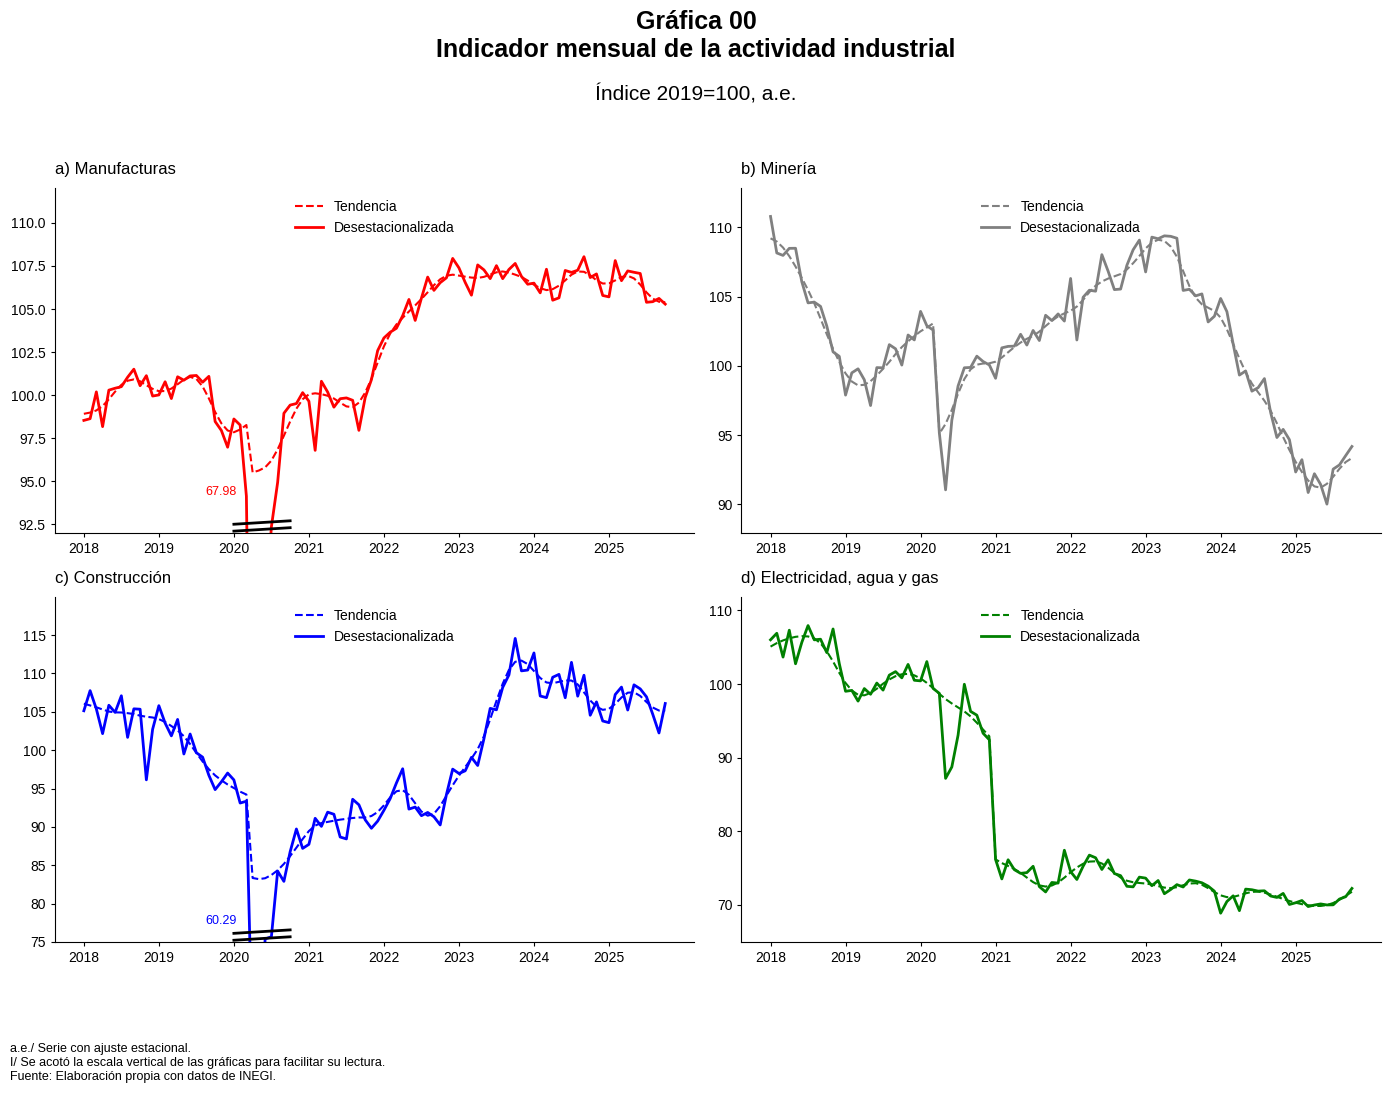

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Tipografía
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'Liberation Sans']
plt.rcParams['axes.unicode_minus'] = False

# Ensure the index is PeriodIndex('Q') for consistent x-axis handling
df_plot = base_filtrada.copy().sort_index()
df_plot.index = df_plot.index.to_period('M') # Convert to monthly period for consistency with previous plotting logic

# Define the series to plot and their colors
series_to_plot = {
    'Manufacturas': {'desest': 'Manufacturas Desest (2019=100)', 'tenden': 'Manufacturas Tenden (2019=100)', 'color': 'red', 'title_prefix': 'a)'},
    'Minería': {'desest': 'Minería Desest (2019=100)', 'tenden': 'Minería Tenden (2019=100)', 'color': 'gray', 'title_prefix': 'b)'},
    'Construcción': {'desest': 'Construcción Desest (2019=100)', 'tenden': 'Construcción Tenden (2019=100)', 'color': 'blue', 'title_prefix': 'c)'},
    'Electricidad, agua y gas': {'desest': 'Electricidad, agua y gas Desest (2019=100)', 'tenden': 'Electricidad, agua y gas Tenden (2019=100)', 'color': 'green', 'title_prefix': 'd)'}
}

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=False) # Increased figure size
axes = axes.flatten() # Flatten the 2x2 array of axes for easy iteration

# Create numeric x-axis
x = np.arange(len(df_plot))

# X-axis labels (only years for monthly data)
year_labels = df_plot.index.strftime('%Y').unique()
jan_indices = [i for i, date in enumerate(df_plot.index) if date.month == 1]
start_year = df_plot.index.year.min()
end_year = df_plot.index.year.max()
jan_x_ticks = []
jan_x_labels = []
for i in jan_indices:
    if df_plot.index[i].year >= start_year and df_plot.index[i].year <= end_year:
        jan_x_ticks.append(x[i])
        jan_x_labels.append(str(df_plot.index[i].year))

# Calculate the starting x-coordinate for 2020 and the line length
x_start_2020 = jan_x_ticks[jan_x_labels.index('2020')] # x-coordinate for the beginning of 2020
line_length = x[int(len(x) / 10)] - x[0] # Original line length

# Calculate the x-coordinate for octember 2019
x_oct_2019_idx = df_plot.index.get_loc(pd.Period('2019-10', freq='M'))
x_oct_2019 = x[x_oct_2019_idx]

for i, (sector, data) in enumerate(series_to_plot.items()):
    ax = axes[i]
    color = data['color']
    title_prefix = data['title_prefix']

    # Plot Tendencia (dashed line)
    ax.plot(
        x,
        df_plot[data['tenden']],
        color=color,
        label='Tendencia',
        linestyle='--'
    )

    # Plot Desestacionalizada (solid line)
    ax.plot(
        x,
        df_plot[data['desest']],
        color=color,
        linewidth=2,
        label='Desestacionalizada'
    )

    # Linea horizontal en cero
    ax.axhline(0, color='lightgray', linewidth=0.8)

    # X-axis labels
    ax.set_xticks(jan_x_ticks)
    ax.set_xticklabels(jan_x_labels)

    # Y-axis limits (dynamic for each subplot)
    min_val_desest = df_plot[data['desest']].min()
    max_val_desest = df_plot[data['desest']].max()
    min_val_tenden = df_plot[data['tenden']].min()
    max_val_tenden = df_plot[data['tenden']].max()

    min_overall = min(min_val_desest, min_val_tenden)
    max_overall = max(max_val_desest, max_val_tenden)

    padding_y = (max_overall - min_overall) * 0.1

    # Set y-axis start for specific panels
    if sector == 'Construcción':
        ax.set_ylim(75, max_overall + padding_y)
    elif sector in ['Manufacturas']:
        ax.set_ylim(92, max_overall + padding_y)
    else: # For 'Minería'
        ax.set_ylim(min_overall - padding_y, max_overall + padding_y)

    # Add a slightly inclined line for panels 'a', 'c', and 'd' ('Manufacturas', 'Construcción', 'Electricidad, agua y gas')
    if sector in ['Manufacturas', 'Construcción']:
        ymin, ymax_current = ax.get_ylim()
        line_y_start = ymin + (ymax_current - ymin) * 0.025
        line_y_end = ymin + (ymax_current - ymin) * 0.035 # Slight inclination
        ax.plot([x_start_2020, x_start_2020 + line_length], [line_y_start, line_y_end], color='black', linewidth=2)
        # Second parallel line
        line_y_start_2 = ymin + (ymax_current - ymin) * 0.005 # Slightly lower than the first line
        line_y_end_2 = ymin + (ymax_current - ymin) * 0.015 # Slightly lower than the first line_y_end
        ax.plot([x_start_2020, x_start_2020 + line_length], [line_y_start_2, line_y_end_2], color='black', linewidth=2)

        # Add labels for minimum value of deseasonalized series
        desest_col = data['desest']
        min_val_desest = df_plot[desest_col].min()
        min_date_desest = df_plot[desest_col].idxmin() # This returns a Period('YYYY-MM', freq='M')
        min_x_coord_desest = x[df_plot.index.get_loc(min_date_desest)] # Get x-coord of actual minimum

        # Position the text slightly above ymin (current subplot's lower limit)
        text_y_position = ymin + 2 # Increased offset for better visibility

        # Determine x-coordinate for annotation text, with left shift for 'Manufacturas' and 'Construcción'
        annotation_x_pos = min_x_coord_desest
        if sector == 'Manufacturas' or sector == 'Construcción':
            annotation_x_pos = min_x_coord_desest - 5 # Shift left by 3 units (e.g., 3 months)

        ax.annotate(f'{min_val_desest:.2f}',
                    xy=(min_x_coord_desest, ymin), # Actual data point should be aligned with the actual ymin
                    xytext=(annotation_x_pos, text_y_position),        # Text position (aligned with min_x_coord_desest, with offset)
                    arrowprops=dict(facecolor=color, shrink=0.05, width=0, headwidth=0, headlength=0),
                    fontsize=9, color=color, ha='center', va='bottom')

    # Titles and format
    ax.set_title(f'{title_prefix} {sector}', loc='left', pad=10)
    ax.legend(frameon=False, loc='upper center') # Legend for each subplot

    # Clean style
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(axis='x', length=3, labelbottom=True) # Ensure x-axis tick marks and labels are visible
    ax.tick_params(axis='y', length=3) # Ensure y-axis tick marks are visible
    ax.grid(axis='y', linestyle='', alpha=0.7)

# Adjust layout and add overall title and footnote
fig.suptitle('Gráfica 00\nIndicador mensual de la actividad industrial', ha='center', y=1.02, fontsize=18, fontweight='bold') # Use 'color' and 'fontweight'
#Subtítulo
plt.figtext(
    0.5, 0.93, # Adjust position to be below suptitle and centered
    'Índice 2019=100, a.e.',
    ha='center', # Center horizontally
    fontsize=15
)
# Footnote
plt.figtext(
    0.01, -0.05, # Adjust position to avoid overlap with subtitle or main title
    'a.e./ Serie con ajuste estacional.\n' # Added line break
    'I/ Se acotó la escala vertical de las gráficas para facilitar su lectura.\n'
    'Fuente: Elaboración propia con datos de INEGI.',
    ha='left',
    fontsize=9
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjusted rect to have 4 values
plt.show()

# Gráfica 5: Indicadores de la producción industrial

Llamar a la API

In [ ]:
import requests
import json
import pandas as pd
from functools import reduce

# Configuración
token = '337db32f-2268-33f9-43e8-c853b84b6ee9'
# Define series_ids as a dictionary to correctly map IDs to names
series_ids = {
    '737261': "Manufacturas Desest",
    '737264': "Manufacturas Tenden",
    '737240': "Minería Desest",
    '737243': "Minería Tenden",
    '737254': "Construcción Desest",
    '737257': "Construcción Tenden",
    '737247': "Electricidad, agua y gas Desest",
    '737250': "Electricidad, agua y gas Tenden"

}

# Modify obtener_serie to accept and use the series_name for column renaming
def obtener_serie(serieID, token, serie_name):
    url = f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{serieID}/es/00/false/BIE-BISE/2.0/{token}?type=json'
    response = requests.get(url)

    if response.status_code == 200:
        content = json.loads(response.content)
        observations = content['Series'][0]['OBSERVATIONS']

        # Crear DataFrame temporal
        df = pd.DataFrame(observations)

        # Mantener solo fecha y valor, renombrando el valor con el nombre descriptivo
        df = df[['TIME_PERIOD', 'OBS_VALUE']].copy()
        df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')
        df.rename(columns={'OBS_VALUE': serie_name}, inplace=True) # Use descriptive name here

        return df
    else:
        print(f"Error al consultar la serie {serieID} ({serie_name}), código {response.status_code}")
        return None

# 1. Obtener todas las series en una lista
# Iterate over dictionary items to get both ID and name
lista_dataframes = [obtener_serie(id, token, name) for id, name in series_ids.items()]

# 2. Eliminar posibles errores (Nones) de la lista
lista_dataframes = [df for df in lista_dataframes if df is not None]

# 3. Unir todos los DataFrames por la columna 'TIME_PERIOD'
# Asegúrate de que lista_dataframes no esté vacío para evitar un error con reduce
if lista_dataframes:
    df_final = reduce(lambda left, right: pd.merge(left, right, on='TIME_PERIOD', how='outer'), lista_dataframes)
else:
    df_final = pd.DataFrame() # O maneja el caso de no datos de otra manera

# Ordenar por fecha para que tenga sentido cronológico
df_final = df_final.sort_values('TIME_PERIOD').reset_index(drop=True)

# Establecer TIME_PERIOD como index
df_final = df_final.set_index('TIME_PERIOD')

print(df_final)

             Manufacturas Desest  Manufacturas Tenden  Minería Desest  \
TIME_PERIOD                                                             
1993/01                56.769541            58.257264      103.826568   
1993/02                59.072152            58.545996      104.848361   
1993/03                59.775981            58.825780      106.027502   
1993/04                59.202204            59.039816      106.687303   
1993/05                58.829685            59.198748      106.179290   
...                          ...                  ...             ...   
2025/06               107.041914           106.483725       85.264959   
2025/07               105.369411           106.028770       87.656494   
2025/08               105.404425           105.668488       87.940957   
2025/09               105.594440           105.485219       88.577428   
2025/10               105.263446           105.454817       89.204034   

             Minería Tenden  Construcción Desest  

In [ ]:
import requests
import json
import pandas as pd
from functools import reduce

# Configuración
token = '337db32f-2268-33f9-43e8-c853b84b6ee9'
# Define series_ids as a dictionary to correctly map IDs to names
series_ids = {
    '737261': "Manufacturas Desest",
    '737264': "Manufacturas Tenden",
    '737240': "Minería Desest",
    '737243': "Minería Tenden",
    '737254': "Construcción Desest",
    '737257': "Construcción Tenden",
    '737247': "Electricidad, agua y gas Desest",
    '737250': "Electricidad, agua y gas Tenden"

}

# Modify obtener_serie to accept and use the series_name for column renaming
def obtener_serie(serieID, token, serie_name):
    url = f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{serieID}/es/00/false/BIE-BISE/2.0/{token}?type=json'
    response = requests.get(url)

    if response.status_code == 200:
        content = json.loads(response.content)
        observations = content['Series'][0]['OBSERVATIONS']

        # Crear DataFrame temporal
        df = pd.DataFrame(observations)

        # Mantener solo fecha y valor, renombrando el valor con el nombre descriptivo
        df = df[['TIME_PERIOD', 'OBS_VALUE']].copy()
        df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')
        df.rename(columns={'OBS_VALUE': serie_name}, inplace=True) # Use descriptive name here

        return df
    else:
        print(f"Error al consultar la serie {serieID} ({serie_name}), código {response.status_code}")
        return None

# 1. Obtener todas las series en una lista
# Iterate over dictionary items to get both ID and name
lista_dataframes = [obtener_serie(id, token, name) for id, name in series_ids.items()]

# 2. Eliminar posibles errores (Nones) de la lista
lista_dataframes = [df for df in lista_dataframes if df is not None]

# 3. Unir todos los DataFrames por la columna 'TIME_PERIOD'
# Asegúrate de que lista_dataframes no esté vacío para evitar un error con reduce
if lista_dataframes:
    df_final = reduce(lambda left, right: pd.merge(left, right, on='TIME_PERIOD', how='outer'), lista_dataframes)
else:
    df_final = pd.DataFrame() # O maneja el caso de no datos de otra manera

# Ordenar por fecha para que tenga sentido cronológico
df_final = df_final.sort_values('TIME_PERIOD').reset_index(drop=True)

# Establecer TIME_PERIOD como index
df_final = df_final.set_index('TIME_PERIOD')

print(df_final)

             Manufacturas Desest  Manufacturas Tenden  Minería Desest  \
TIME_PERIOD                                                             
1993/01                56.769541            58.257264      103.826568   
1993/02                59.072152            58.545996      104.848361   
1993/03                59.775981            58.825780      106.027502   
1993/04                59.202204            59.039816      106.687303   
1993/05                58.829685            59.198748      106.179290   
...                          ...                  ...             ...   
2025/06               107.041914           106.483725       85.264959   
2025/07               105.369411           106.028770       87.656494   
2025/08               105.404425           105.668488       87.940957   
2025/09               105.594440           105.485219       88.577428   
2025/10               105.263446           105.454817       89.204034   

             Minería Tenden  Construcción Desest  

# Gráfica 6: IGAE de actividades terciarias